In [188]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from six.moves import reload_module

from GPy.kern import Matern52
from GPy.models import GPRegression

from emukit.core import ParameterSpace, ContinuousParameter
from emukit.bayesian_optimization.acquisitions \
    import ExpectedImprovement as ExpectedImprovement_std
from emukit.bayesian_optimization.acquisitions \
    import NegativeLowerConfidenceBound as NegativeLowerConfidenceBound_std

import sys
sys.path.append("..")
from l2_bayes_opt.chi_statistics import norm_dist
from l2_bayes_opt.l2_acquisitions.expected_improvement \
    import ExpectedImprovement as ExpectedImprovement_L2
from l2_bayes_opt.l2_acquisitions.negative_lower_confidence_bound \
    import NegativeLowerConfidenceBound as NegativeLowerConfidenceBound_L2

In [189]:
from matplotlib import rc
title_fontsize = 28
rc('text', usetex=True)
label_fontsize = 34
tick_fontsize = 22

In [198]:
target = -2.5
xmin, xmax = 0., 2*np.pi

def f_y(x, noise=0.5):
    y = -3*x*np.sin(0.75*x) + np.exp(-2*x)
    return y + norm.rvs(size=y.shape)*np.sqrt(noise)

def f_d(x, noise=0.5):
    return (f_y(x, noise=noise) - target)**2

# Emperical minima
n_mins = 2
x_r = np.linspace(xmin, xmax, 10000)
d_mins = x_r[f_d(x_r[:, None], noise=0).ravel().argsort()[:n_mins]]

In [199]:
num_data_points = 6
X0 = np.linspace(xmin, xmax, num_data_points)[:, None]
Y0 = f_y(X0)
D0 = (Y0 - target)**2

# Standard model
kernel = Matern52(X0.shape[-1])
model_std = GPRegression(X0, D0, normalizer=True, kernel=kernel)
model_std.optimize_restarts(robust=True, verbose=False)
ei_std = ExpectedImprovement_std(model=model_std)
lcb_std = NegativeLowerConfidenceBound_std(
    model=model_std, beta=1)

# L2 model
kernel = Matern52(X0.shape[-1])
model_l2 = GPRegression(X0, Y0, normalizer=True, kernel=kernel)
model_l2.optimize_restarts(robust=True, verbose=False)
ei_l2 = ExpectedImprovement_L2(model=model_l2, target=target)
lcb_l2 = NegativeLowerConfidenceBound_L2(
    model=model_l2, target=target, beta=1)

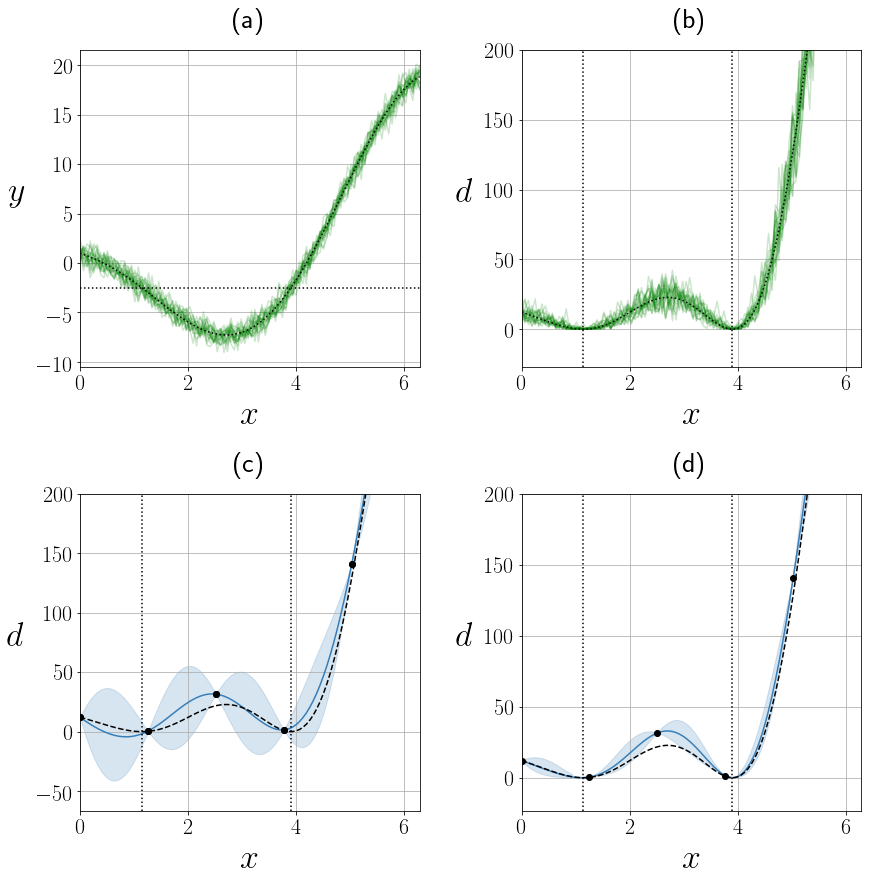

In [200]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
ax1, ax2, ax3, ax4 = axes.ravel()
x_r = np.linspace(xmin, xmax, 100)
n_draws = 20
y_draws = [f_y(x_r[:, None]) for _ in range(n_draws)]
for y in y_draws:
    ax1.plot(x_r, y, color=(0, 0.5, 0, 0.2))
y_clean = f_y(x_r[:, None], noise=0)
ax1.plot(x_r, y_clean, "k:")
ax1.axhline(y=target, color="k", linestyle=":")

d_draws = [f_d(x_r[:, None]) for _ in range(n_draws)]
for d in d_draws:
    ax2.plot(x_r, d, color=(0, 0.5, 0, 0.2))
d_clean = f_d(x_r[:, None], noise=0)
ax2.plot(x_r, d_clean, "k:")

q_low, q_mid, q_high = model_std.predict_quantiles(x_r[:, None], (2.5, 50, 97.5))
color = plt.cm.Set1(1)[:3]
ax3.plot(x_r, q_mid, color=color)
ax3.plot(X0, D0, color="k", marker="o", linestyle="")
ax3.fill_between(x_r, q_low.ravel(), q_high.ravel(),
                 color=color + (.2,))
ax3.plot(x_r, d_clean, color="k", linestyle="--")

m, v = model_l2.predict(x_r[:, None])
q_low, q_mid, q_high = norm_dist._ncx2_ppf((0.025, 0.5, 0.975), target, m, np.sqrt(v), False).T
color = plt.cm.Set1(1)[:3]
ax3.plot(X0, D0, color="k", marker="o", linestyle="")
ax4.plot(x_r, q_mid, color=color)
ax4.fill_between(x_r, q_low, q_high, color=color + (.2,))
ax4.plot(x_r, d_clean, color="k", linestyle="--")
ax4.plot(X0, D0, color="k", marker="o", linestyle="")

for c, ax in zip("abcd", axes.ravel()):
    ax.grid()
    ax.tick_params(labelsize=tick_fontsize)
    ttl = ax.set_title("(" + c + ")", fontsize=title_fontsize)
    ttl.set_position([.5, 1.05])
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel("$x$", fontsize=label_fontsize)
    
    if c == "a":
        ylabel = "$y$"
    else:
        ylabel = "$d$"
        
    ax.set_ylabel(ylabel, fontsize=label_fontsize, labelpad=20, rotation=0)
        
for ax in axes.ravel()[1:]:
    ax.set_ylim(None, 200)
    for x in d_mins:
        l = ax.axvline(x=x, color="k", linestyle=":")

plt.subplots_adjust(wspace=0.3, hspace=0.4)
fig.savefig("report_figures/posterior_comparison.png")

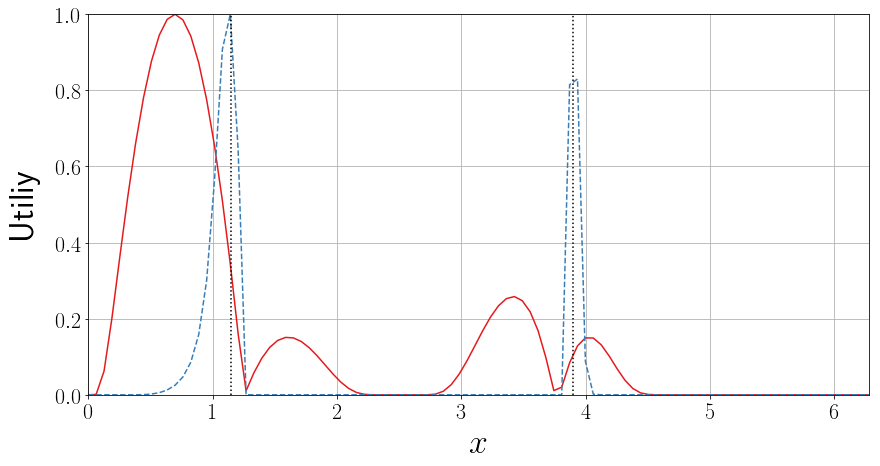

In [201]:
fig, ax = plt.subplots(figsize=(14, 7))


for i, acq in enumerate([ei_std, ei_l2]):
    ls = ["-", "--"][i]
    util = acq.evaluate(x_r[:, None])
    util = (util-util.min()) / (util.max() - util.min())
    ax.plot(x_r, util, color=plt.cm.Set1(i), linestyle=ls)

# ax.plot(X0.ravel(), [0]*len(X0), 'ko')

for x in d_mins:
    ax.axvline(x=x, color="k", linestyle=':')
ax.grid()
ax.set_xlabel("$x$", fontsize=label_fontsize)
ax.set_ylabel("Utiliy", fontsize=label_fontsize, labelpad=15)
ax.set_xlim(xmin, xmax)
ax.tick_params(labelsize=tick_fontsize)
ax.set_ylim(0, 1)
fig.savefig("report_figures/acquisition_comparison.")

# Multi-output function

In [170]:
target = np.array([np.pi, np.pi])

def f_y(x, noise=0.2):
    # y1 = np.sin(x)*np.pi+np.pi
    y1 = 2*np.pi - x
    y2 = x
    Y = np.hstack([y1, y2])
    return Y + norm.rvs(size=Y.shape)*np.sqrt(noise)

def f_d(x, noise=0.2):
    return ((f_y(x, noise=noise)-target)**2).sum(axis=1)[:, None]

x_min = np.pi

In [182]:
num_data_points = 6
X0 = np.linspace(xmin, xmax, num_data_points)[:, None]
Y0 = f_y(X0)
D0 = ((Y0 - target)**2).sum(axis=1)[:, None]

# Standard model
kernel = Matern52(X0.shape[-1])
model_std = GPRegression(X0, D0, normalizer=True, kernel=kernel)
model_std.optimize_restarts(robust=True, verbose=False)
ei_std = ExpectedImprovement_std(model=model_std)
lcb_std = NegativeLowerConfidenceBound_std(
    model=model_std, beta=1)

# L2 model
kernel = Matern52(X0.shape[-1])
model_l2 = GPRegression(X0, Y0, normalizer=True, kernel=kernel)
model_l2.optimize_restarts(robust=True, verbose=False)
ei_l2 = ExpectedImprovement_L2(model=model_l2, target=target)
lcb_l2 = NegativeLowerConfidenceBound_L2(
    model=model_l2, target=target, beta=1)

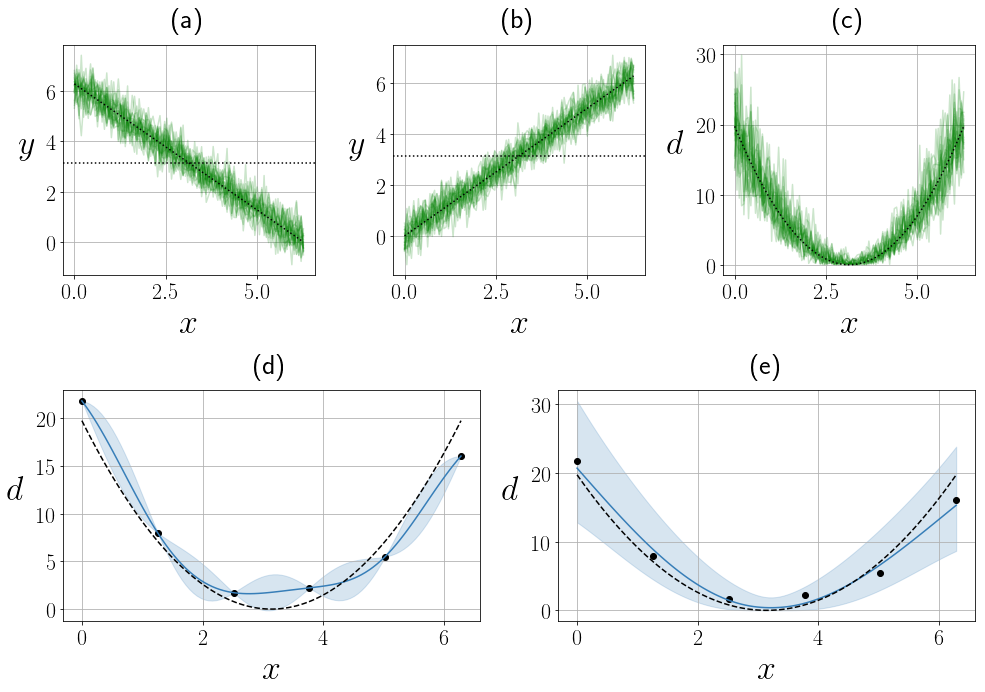

In [187]:
x_r = np.linspace(xmin, xmax, 100)

grid = plt.GridSpec(2, 6, wspace=0.90, hspace=0.5)

ax_obj1 = plt.subplot(grid[0, :2])
ax_obj2 = plt.subplot(grid[0, 2:4])
ax_dist = plt.subplot(grid[0, 4:])

fig = ax_obj1.figure
fig.set_size_inches((14, 10))

n_draws = 20
y_draws = [f_y(x_r[:, None]) for _ in range(n_draws)]
for i in range(n_draws):
    Y = f_y(x_r[:, None])
    D = ((Y-target)**2).sum(axis=1)
    ax_obj1.plot(x_r, Y[:, 0], color=(0, 0.5, 0, 0.2))
    ax_obj2.plot(x_r, Y[:, 1], color=(0, 0.5, 0, 0.2))
    ax_dist.plot(x_r, D, color=(0, 0.5, 0, 0.2))

y_clean = f_y(x_r[:, None], noise=0)
d_clean = ((y_clean-target)**2).sum(axis=1)
ax_obj1.plot(x_r, y_clean[:, 0], "k:")
ax_obj2.plot(x_r, y_clean[:, 1], "k:")
ax_dist.plot(x_r, d_clean, "k:")

ax_obj1.axhline(y=target[0], color="k", linestyle=":")
ax_obj2.axhline(y=target[1], color="k", linestyle=":")

ax_gp_std = plt.subplot(grid[1, :3])
ax_gp_l2 = plt.subplot(grid[1, 3:])

q_low, q_mid, q_high = model_std.predict_quantiles(x_r[:, None], (2.5, 50, 97.5))
color = plt.cm.Set1(1)[:3]
ax_gp_std.plot(X0, D0, color="k", marker="o", linestyle="")
ax_gp_std.plot(x_r, q_mid, color=color)
ax_gp_std.fill_between(x_r, q_low.ravel(), q_high.ravel(), color=color + (0.2,))
ax_gp_std.plot(x_r, d_clean, color="k", linestyle="--")

m, v = model_l2.predict(x_r[:, None])
q_low, q_mid, q_high = norm_dist._ncx2_ppf((0.025, 0.5, 0.975), target, m, np.sqrt(v), False).T
color = plt.cm.Set1(1)[:3]
ax_gp_l2.plot(X0, D0, color="k", marker="o", linestyle="")
ax_gp_l2.plot(x_r, q_mid, color=color)
ax_gp_l2.fill_between(x_r, q_low, q_high, color=color + (.2,))
ax_gp_l2.plot(x_r, d_clean, color="k", linestyle="--")

axes = (ax_obj1, ax_obj2, ax_dist, ax_gp_std, ax_gp_l2)
for c, ax in zip("abcde", axes):
    ax.grid()
    ax.set_xlabel("$x$", fontsize=label_fontsize)
    ax.tick_params(labelsize=tick_fontsize)
    ttl = ax.set_title("(" + c + ")", fontsize=title_fontsize)
    ttl.set_position([.5, 1.05])
    
    ylabel = "$y$" if c in "ab" else "$d$"
    ax.set_ylabel(ylabel, fontsize=label_fontsize, labelpad=20, rotation=0)

plt.figure(fig.number)
plt.subplots_adjust(left=0.075, bottom=0.1, right=0.98, top=0.90)
fig.savefig("report_figures/posterior_comparison_multiple_outputs.png")

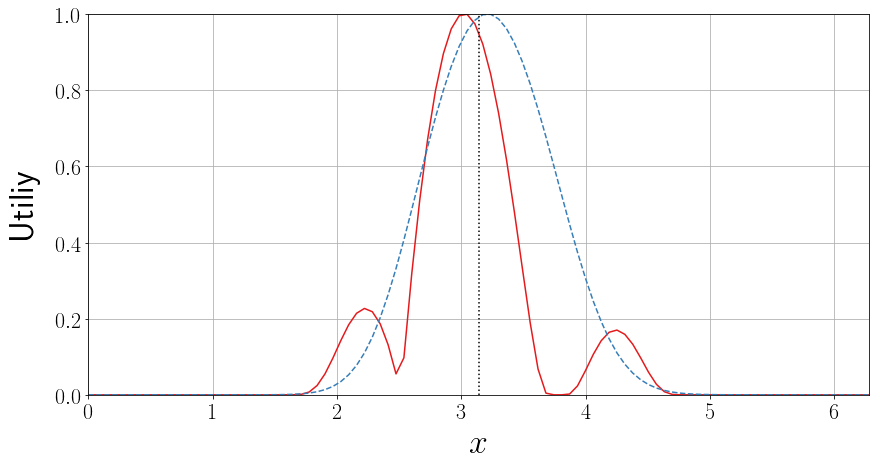

In [185]:
fig, ax = plt.subplots(figsize=(14, 7))

for i, acq in enumerate([ei_std, ei_l2]):
    ls = ["-", "--"][i]
    util = acq.evaluate(x_r[:, None])
    util = (util-util.min()) / (util.max() - util.min())
    ax.plot(x_r, util, color=plt.cm.Set1(i), linestyle=ls)

# ax.plot(X0.ravel(), [0]*len(X0), 'ko')

ax.axvline(x=x_min, color="k", linestyle=':')
ax.grid()
ax.set_xlabel("$x$", fontsize=label_fontsize)
ax.set_ylabel("Utiliy", fontsize=label_fontsize, labelpad=15)
ax.set_xlim(xmin, xmax)
ax.tick_params(labelsize=tick_fontsize)
ax.set_ylim(0, 1)
fig.savefig("report_figures/acquisition_comparison_multiple_outputs.png")